In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt  
from scipy.stats import f_oneway, ttest_ind
from statsmodels.stats.multitest import fdrcorrection
import math

from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg
%matplotlib inline

In [3]:
def do_t_test_on_whole_data_frame(df: pd.DataFrame, group_of_interest: str='CHDM') -> pd.DataFrame:
    """
    :df: a dataframe with at least 4 columns 'patient_group' and 'intensity' and 'type' and 'normalization_scenario'
     type could be before_normalization adn after_normalization

    Returns
    A pandas data frame after doing all t_Tests across all the biomarkers

    """
    final_results = pd.DataFrame([do_t_test_per_biomarker(df,x,group_of_interest=group_of_interest) for x in df.biomarker.unique().tolist()])
    final_results['p_value_before_normalization'] = final_results['before_normalization'].apply(lambda x:x[1])
    final_results['p_value_after_normalization'] = final_results['after_normalization'].apply(lambda x:x[1])
    final_results['fdr_before_normalization'] = fdrcorrection(final_results.p_value_before_normalization.to_numpy(), alpha=0.01, method='indep', is_sorted=False)[1]
    final_results['fdr_after_normalization'] = fdrcorrection(final_results.p_value_after_normalization.to_numpy(), alpha=0.01, method='indep', is_sorted=False)[1]
    final_results['P_padjusted_before_normalization'] = final_results['fdr_before_normalization'].apply(lambda x:math.log10(1/x))
    final_results['P_padjusted_after_normalization'] = final_results['fdr_after_normalization'].apply(lambda x:math.log10(1/x))
    final_results['normalization_scenario'] = df['normalization_scenario'].unique().tolist()[0]
    return final_results

def t_test(x: tuple, y: tuple) -> tuple:
    """ 
    Performs t_test from two numerical tuples as the two groups
    :returns : F_statistics and P_values as a tuple
    
    """
    t_test = ttest_ind(x, y)
    F = list(t_test)[0]
    p = list(t_test)[1]
    return F, p

def do_t_test_per_entity(df: pd.DataFrame, group_of_interest: str='CHDM') -> tuple:
    """
    :df: a datafrme with at least two columns 'patient_group' and 'intensity'
    Returns
    Tuple with F-statitistics and P_values between two disease state like CHDM and non CHDM

    """
    df = df.dropna(subset=['intensity'])
    g1=tuple(df['intensity'][df.patient_group == group_of_interest])
    g2=tuple(df['intensity'][df.patient_group != group_of_interest])
    return t_test(g1,g2)

def do_t_test_per_biomarker(df: pd.DataFrame, biomarker_name: str, group_of_interest: str='CHDM') ->dict:
    """
    :df: a datafrme with at least three columns 'patient_group' and 'intensity' and 'type'
    Returns
    A dictionary with the keys entity, before_normalization, after_normalization, biomarker

    """
    df = df[df.biomarker == biomarker_name]
    df_before_normalization = df[df.type == 'before_normalization']
    df_after_normalization = df[df.type == 'after_normalization']
    before_normalization_results = do_t_test_per_entity(df_before_normalization, group_of_interest)
    after_normalization_results = do_t_test_per_entity(df_after_normalization, group_of_interest)
    return {'before_normalization': before_normalization_results,
            'after_normalization': after_normalization_results,
            'entity': group_of_interest,
            'biomarker': biomarker_name}

In [4]:
   
def make_swarm_df_per_biomarker(after_normalization_df, before_normalization_df, entity, protein_name, patients_interest):
    common_samples = [x for x in after_normalization_df.columns if x in before_normalization_df.columns]
    after_normalization = pd.DataFrame(after_normalization_df.loc[protein_name, common_samples])
    after_normalization['type'] = 'after_normalization'
    after_normalization['patients'] = after_normalization.index
    before_normalization = pd.DataFrame(before_normalization_df.loc[protein_name, common_samples])
    before_normalization['type'] = 'before_normalization'
    before_normalization['patients'] = before_normalization.index    
    final_df = pd.concat([before_normalization, after_normalization])
    final_df.columns = ['intensity','type','patients']
    final_df['patient_group'] = 'others'
    final_df['patient_group'][final_df['patients'].isin(patients_interest)] = entity
    final_df['biomarker'] = protein_name
    return final_df

def get_df(report_dir_norm: str, intensity_file_name: str) -> pd.DataFrame:
    fp_path = report_dir_norm + intensity_file_name
    df = pd.read_csv(fp_path)
    df = df.set_index('Gene names')
    df = df.loc[:, ~df.columns.str.contains('Identification')]
    return df 

In [15]:
# Load pubmed mining data

text_mining_result =  '/media/kusterlab/users_files/Cecilia_Jensen/Paper/biomarker_separation_figure2/publications_frequency_SFT_19JAN2024.csv' 

# publications_frequency_CHDM_18JAN2024.csv
#'publications_frequency_chordoma_14NOV2023.xlsx'
pubmed_results_df = pd.read_csv(text_mining_result)

# Load metadata
general_metadata_path = '/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_MTBs_Evaluation/'
metadata_file = 'METADATA_PAPER_Dez23_Batch158_genannot.xlsx'
metadata_df = pd.read_excel(general_metadata_path + metadata_file)

# Prepare load full proteome data
general_directory_path = '/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/'
intensity_file_name = 'preprocessed_fp.csv'

# Load before normalization data
# report_dir_before_norm = general_directory_path + '2023.12.14_CJ_PAPER_non_normalized/'
report_dir_before_norm = general_directory_path + '2023.12.14_CJ_PAPER_non_normalized_except_redist_of_ms1_only/'

fp_before_norm_df = get_df(report_dir_before_norm, intensity_file_name)


# Load after normalization data
after_normalization_path = {
    #'ms1Redist':'/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.11.29_AhS_PANCANCER_157_non_normalized_except_redist_of_ms1_only/',
    #'ms1MNCN+ms1Redist':'/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.11.29_AhS_PANCANCER_157_non_normalized+redist_ms1+ms1/',
    #'ms3MNCN+ms1Redist':'/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.11.29_AhS_PANCANCER_157_non_normalized_ms3_only+redist_ms1/',
    'AllNormalizations':'/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2024.01.16_CJ_PAPER_cohort_new_PSP/',   #2023.11.27_CJ_PANCANCER_157/',
    #'ms3MNCN': '/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.11.29_AhS_PANCANCER_157_non_normalized_ms3_only/'
    }

all_normalized_dfs = [get_df(x, intensity_file_name) for x in after_normalization_path.values()]


In [16]:
entity = 'SFT'  # CHDM
main_targets = ['NAB2', 'STAT6', 'IGF2']
#['ACAN', 'KRT8', 'RAB3A', 'CD109', 'S100A1', 'VIM', 'ACE', 'CDKN2A-p16;CDKN2B', 'MTAP', 'RHEB']


patients_interest = metadata_df['Sample name'][metadata_df.code_oncotree == entity]


all_swarm_df = []
for label, after_normalization_df in zip(after_normalization_path.keys(), all_normalized_dfs):
    main_targets = [x for x in fp_before_norm_df.index.tolist() if x in main_targets]
    swarm_dfs = [make_swarm_df_per_biomarker(after_normalization_df, fp_before_norm_df, entity, target, patients_interest) for target in main_targets]
    final_swarm_df = pd.concat(swarm_dfs)
    final_swarm_df['normalization_scenario'] = label
    all_swarm_df.append(final_swarm_df)
    
concatenated_swarm_dfs = pd.concat(all_swarm_df)
# concatenated_swarm_dfs.to_csv('/media/kusterlab/users_files/Cecilia_Jensen/Paper/biomarker_separation_figure2/CHDM_concatenated_swarm_inputs.csv')

In [17]:
concatenated_swarm_dfs

,intensity,type,patients,patient_group,biomarker,normalization_scenario
I007-031-108742,7.899987,before_normalization,I007-031-108742,others,STAT6,AllNormalizations
I043-005-95540,7.397426,before_normalization,I043-005-95540,others,STAT6,AllNormalizations
I007-020-1007541,8.010263,before_normalization,I007-020-1007541,others,STAT6,AllNormalizations
I007-039-130734,7.921297,before_normalization,I007-039-130734,others,STAT6,AllNormalizations
I043-001-80842,7.695233,before_normalization,I043-001-80842,others,STAT6,AllNormalizations
...,...,...,...,...,...,...
H021-86LW15-T2-Q1,7.411138,after_normalization,H021-86LW15-T2-Q1,others,NAB2,AllNormalizations
H021-8JDE58-M2-Q1,7.619727,after_normalization,H021-8JDE58-M2-Q1,others,NAB2,AllNormalizations
H021-A6LHFV-M7-Q1,7.652709,after_normalization,H021-A6LHFV-M7-Q1,others,NAB2,AllNormalizations
H021-J75F36-M2-Q1,7.429747,after_normalization,H021-J75F36-M2-Q1,others,NAB2,AllNormalizations


In [18]:
res_df = [do_t_test_on_whole_data_frame(x) for x in all_swarm_df]
t_test_res = pd.concat(res_df)
# t_test_res.to_csv('/media/kusterlab/users_files/Cecilia_Jensen/Paper/biomarker_separation_figure2/CHDM_t_test_results.csv')

normalization_df = t_test_res[['biomarker', 'P_padjusted_after_normalization', 'normalization_scenario']]
normalization_df.columns = ['biomarker', 'value','normalization_scenario']

non_normalized_df = t_test_res[['biomarker', 'P_padjusted_before_normalization','normalization_scenario']]
non_normalized_df.columns = ['biomarker', 'value','normalization_scenario']
non_normalized_df = non_normalized_df.drop_duplicates(subset='biomarker')
non_normalized_df.normalization_scenario = 'Not_normalized'

df = pd.concat([non_normalized_df, normalization_df])
df.head()
# df.to_csv('/media/kusterlab/users_files/Cecilia_Jensen/Paper/biomarker_separation_figure2/CHDM_t_statistics_long.csv')

,biomarker,value,normalization_scenario
0,STAT6,NaN,Not_normalized
1,IGF2,NaN,Not_normalized
2,NAB2,NaN,Not_normalized
0,STAT6,NaN,AllNormalizations
1,IGF2,NaN,AllNormalizations


/home/cjensen/miniconda3/envs/initialProjectsEnv/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 110 rows containing non-finite values.


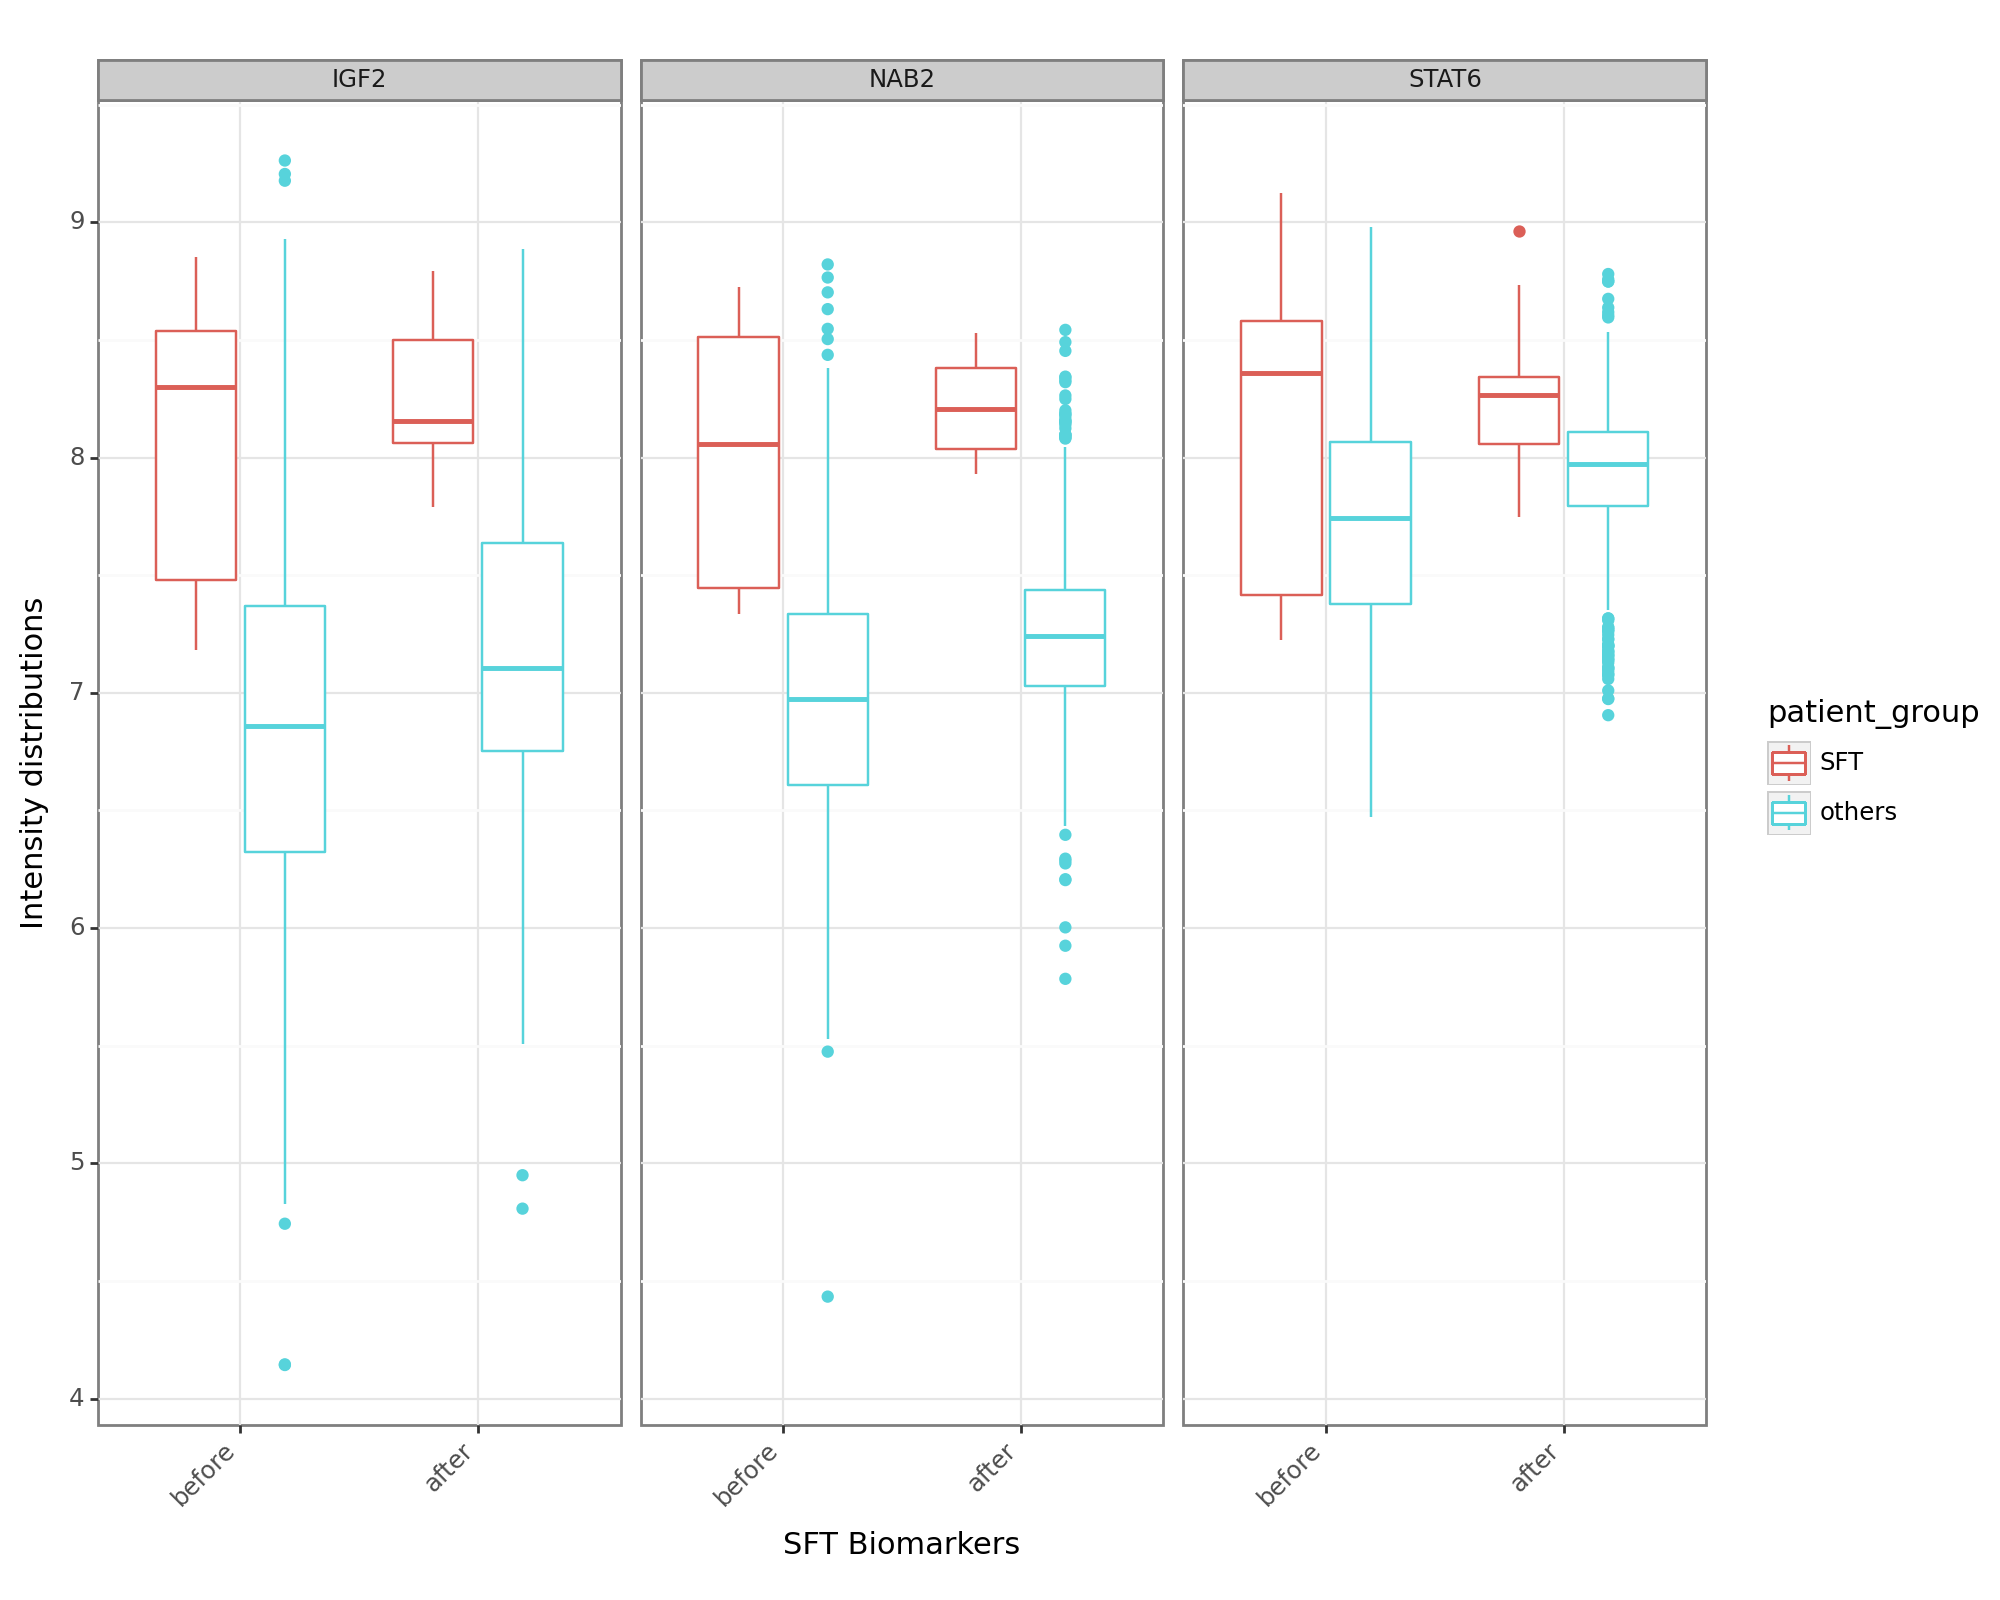

<Figure Size: (1000 x 800)>

In [23]:
from plotnine import ggplot, aes, geom_boxplot, facet_wrap, theme, element_text, labs, geom_bar

# 1- Swarm Plot --------------------------------------------------

# Read the data
df_swarm = concatenated_swarm_dfs #pd.read_csv('concatanated_swarm_inputs.csv')
df_swarm['type'] = df_swarm['type'].replace({'before_normalization': 'before', 'after_normalization': 'after'})
df_swarm['type'] = pd.Categorical(df_swarm['type'], categories=["before", "after"], ordered=True)


# Create the plot
(ggplot(df_swarm, aes(x='type', y='intensity', color='patient_group')) + 
 geom_boxplot(notch=False) + 
 facet_wrap('~ biomarker', nrow=1) +
 theme_bw() + 
 theme(axis_text_x=element_text(angle=45, hjust=1)) +
 labs(x='SFT Biomarkers', y='Intensity distributions') + 
 theme(figure_size=(10, 8))
)


In [25]:
df

,biomarker,value,normalization_scenario
0,STAT6,NaN,Not_normalized
1,IGF2,NaN,Not_normalized
2,NAB2,NaN,Not_normalized
0,STAT6,NaN,AllNormalizations
1,IGF2,NaN,AllNormalizations
2,NAB2,NaN,AllNormalizations


In [24]:

(ggplot(df, aes(x='normalization_scenario', y='value', fill='normalization_scenario')) +
  geom_bar(stat="identity") +
  facet_wrap('~ biomarker', nrow = 1, ncol = 3) +
  theme_bw() + 
  theme(axis_text_x=element_text(angle=45, hjust=1)) +
  xlab('Chordoma Biomarkers') + ylab('-log10 (p_adjusted_value)') +
  theme(figure_size=(10, 8)
)) 



/home/cjensen/miniconda3/envs/initialProjectsEnv/lib/python3.9/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 6 rows containing missing values.


TypeError: cannot unpack non-iterable NoneType object

In [ ]:

(ggplot(mpg)         # defining what data to use
 + aes(x='class')    # defining what variable to use
 + geom_bar(size=20) # defining the type of plot to use
)